In [76]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [77]:
def create_dataframe(txt_path):
    with open(txt_path, 'r') as file:
        lines = file.readlines()

    safran_df = pd.DataFrame(columns=['Date', 'X', 'Y', 'Z', 'M'])
    for i, line in enumerate(lines):
        if "No" not in line:
            data_lst = line.split(" ")
            if len(data_lst) != 8:
                continue

            date = data_lst[1]
            date_lst = date.split("/")
            time = data_lst[2]
            datetime_str = f'{date_lst[2]}-{date_lst[1]}-{date_lst[0]} {time}'
            datetime_obj = pd.to_datetime(datetime_str)

            x_val = float(data_lst[4])
            y_val = float(data_lst[5])
            z_val = float(data_lst[6])
            m_val = float(data_lst[7])

            new_row = {'Date': [datetime_obj], 'X': [x_val], 'Y': [y_val], 'Z': [z_val], 'M': [m_val]}
            safran_df = pd.concat([safran_df, pd.DataFrame(new_row)], axis=0, ignore_index=True)

    safran_df = safran_df.iloc[::-1]
    safran_df.index = safran_df['Date']
    safran_df = safran_df.drop(columns=['Date'])
    return safran_df

In [78]:
def compute_CUSUM(X):
    CUSUM = np.cumsum(X ** 2)
    return CUSUM


def compute_gamma(X, T, m):
    mean_X = np.mean(X)
    r = X - mean_X
    r_squared = r ** 2
    sigma_squared = np.mean(r_squared)

    gamma = np.zeros(m + 1)
    for i in range(0, m + 1):
        gamma_i = np.sum((r_squared[i:T] - sigma_squared) * (r_squared[0:T - i] - sigma_squared))
        gamma[i] = gamma_i / T
    return gamma


def compute_lambda(gamma, m):
    lambda_hat = gamma[0] + 2 * np.sum((1 - np.arange(1, m + 1) / (m + 1)) * gamma[1:m + 1])
    return np.abs(lambda_hat)


def compute_D_prime(CUSUM, T, lambda_hat):
    k = np.arange(T)
    D_prime = (CUSUM - (k + 1) / T * CUSUM[-1]) / np.sqrt(lambda_hat)
    return D_prime


def compute_percentile(D_prime, T, percent=95):
    D_prime_abs = np.abs(D_prime) * np.sqrt(T / 2)
    critical_value = np.percentile(D_prime_abs, percent)
    return critical_value

In [79]:
def set_plot_params(title, ylabel):
    plt.title(title)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(rotation=30, fontsize=12)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))


def calculate_ylim(data):
    ylim_min = min(data) - (max(data) - min(data)) * 0.1
    ylim_max = max(data) + (max(data) - min(data)) * 0.1
    return ylim_min, ylim_max


def draw_graph(data: pd.DataFrame, title: str, ylabel: str, date_lst: list, color="blue"):
    '''
    :param data: 시간 인덱스와 그래프로 표시할 정보가 있는 데이터프레임
    :param title: 그래프 제목
    :param ylabel: 그래프 y축 단위
    :param date_lst: 아웃라이어 날짜인덱스 리스트
    :param color: 그래프 색깔
    :return: 
    '''
    plt.figure(figsize=(10, 5), dpi=400)
    plt.plot(data.index, data.values, color=color)
    for date in date_lst:
        plt.axvline(pd.to_datetime(date), color='red', linestyle='--', label='Highlight Date')
    set_plot_params(title, ylabel)
    ylim_min, ylim_max = calculate_ylim(list(data.values))
    plt.ylim(ylim_min, ylim_max)
    plt.show()

In [80]:
def ol_detect(diff_value, window_size, significant_level):
    lambda_lst = []
    cv_lst = []
    current_lst = []
    ol_lst = []

    for i in tqdm(range(window_size, len(diff_value) + 1, 1)):

        count = 0
        filter = []
        for val in ol_lst:
            if (i - window_size <= val) and (val < i):
                count += 1
                filter.append(val - (i))

        X = diff_value[i - window_size - count: i].copy()

        if len(filter) != 0:
            X = np.delete(X, filter)

        N = len(X)
        T = N
        m = int(T ** (1 / 4))

        # CUSUM 계산
        CUSUM = compute_CUSUM(X)
        # gamma 계산
        gamma = compute_gamma(X, T, m)
        # lambda_hat 계산
        lambda_hat = compute_lambda(gamma, m)
        lambda_lst.append(lambda_hat)
        # D_prime 계산
        D_prime = compute_D_prime(CUSUM, T, lambda_hat)
        # critical value 계산
        critical_value = compute_percentile(D_prime, T, significant_level)
        cv_lst.append(critical_value)
        # 현재 통계량 계산
        current_lst.append(np.abs(D_prime[-2]) * np.sqrt(T / 2))

        if current_lst[-1] > critical_value:
            ol_lst.append(i - 1)

    ol_lst = list(np.where((np.array(current_lst) > np.array(cv_lst)))[0] + window_size)
    print(len(ol_lst))
    return ol_lst

In [128]:
def plot_ol(hour_df, name, ol_lst, number, safran_idx=None, tle_idx=None):
    plt.figure(figsize=(13, 2), dpi=400)
    plt.plot(hour_df[name], color='tab:gray')

    for point in ol_lst:
        # plt.axvline(hour_df.index[point], color='tab:red', linewidth=0.7, linestyle='--')
        plt.scatter(hour_df.index[point], hour_df[name].iloc[point], color='tab:red', s=10)

    if not safran_idx.empty:
        for date in safran_idx:
            if date < pd.Timestamp('2024-08-01'):
                plt.axvline(date, color='tab:blue', linewidth=1, linestyle='--')

    if not tle_idx.empty:
        for date in tle_idx:
            if date < pd.Timestamp('2024-08-01'):
                # plt.axvline(date, color='tab:purple', linewidth=1, linestyle='--')
                plt.scatter(date, 0.01, color='tab:purple', s=30, zorder=5)

    plt.xlabel('Date')
    plt.ylabel('KM')
    plt.savefig(f'File/images/safran/{number}_{window}_{level}.png')
    plt.show()
    # plt.close()

In [129]:
import os

input_dir = 'Database'
output_dir = 'File/images'

number_lst = [39227, 44343, 44349, 44350, 44351, 44353, 44358, 58464, 46267, 53611, 53019, 51961, 47775, 51969, 58722,
              56361, 56289, 56783, 48018, 43823, 45246, 29349, 37265, 42691, 42984, 55841]

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List of files that do not exist in the output directory
missing_dirs = [str(file) for file in number_lst if not os.path.exists(f"{output_dir}/{file}")]

# Create missing files
for directory in missing_dirs:
    dir_path = os.path.join(output_dir, directory)
    os.makedirs(dir_path)

print(f"Created {len(missing_dirs)} missing files in {output_dir}.")

Created 0 missing files in File/images.


In [130]:
LEO_lst = [44343, 44349, 44350, 44351, 44353, 44358, 58464, 46267,
           53611, 53019, 51961, 47775, 51969, 58722, 56361, 56289, 56783, 48018]
GEO_lst = [43823, 45246, 29349, 37265, 42691, 42984, 55841]

# Preprocessing Old

In [131]:
# for number in LEO_lst:
#     name = 'perigee'
#     info_df = pd.read_csv(f'Database/{number}.csv')
#     df_1 = info_df.copy()
#     df_1.loc[:, 'time'] = pd.to_datetime(df_1[['year', 'month', 'day', 'hour', 'minute']])
#     df_1.set_index('time', inplace=True)
#     df_1.drop(columns=['year', 'month', 'day', 'hour', 'minute'], inplace=True)
#     hour_df = df_1[::60].copy()
#     diff_value = np.log(hour_df[name].copy()).diff().fillna(0).values
# 
#     for level in [95, 99]:
#         for window in [24 * 7 * 1, 24 * 7 * 2, 24 * 7 * 4]:
#             print(f'number: {number}, window : {window}, level : {level}')
#             ol_detect(hour_df, diff_value, window, level, number)

In [132]:
# for number in GEO_lst:
#     name = 'longitude'
#     info_df = pd.read_csv(f'Database/{number}.csv')
# 
#     df_1 = info_df.copy()
#     df_1.loc[:, 'time'] = pd.to_datetime(df_1[['year', 'month', 'day', 'hour', 'minute']])
#     df_1 = df_1[df_1.index > '2022-12-31 23:59:59'].copy()
#     df_1.set_index('time', inplace=True)
#     df_1.drop(columns=['year', 'month', 'day', 'hour', 'minute'], inplace=True)
#     hour_df = df_1[::60].copy()
#     diff_value = np.log(hour_df[name].copy()).diff().fillna(0).values
# 
#     for level in [95, 99]:
#         for window in [24 * 7 * 1, 24 * 7 * 2, 24 * 7 * 4]:
#             print(f'number: {number}, window : {window}, level : {level}')
#             ol_detect(hour_df, diff_value, window, level, number)

# Preprocessing New

In [133]:
# for number in LEO_lst:
#     name = 'perigee'
#     info_df = pd.read_csv(f'Database/{number}_new.csv', index_col=0)
#     info_df = info_df[info_df.index > '2022-12-31 23:59:59'].copy()
#     hour_df = info_df[::60].copy()
#     diff_value = np.log(hour_df[name].copy()).diff().fillna(0).values
# 
#     start_date = hour_df.index[0]
#     data_length = len(hour_df)
#     time_index = pd.date_range(start=start_date, periods=data_length, freq='h')
#     hour_df.index = time_index
# 
#     for level in [95, 99]:
#         for window in [24 * 7 * 1, 24 * 7 * 2, 24 * 7 * 4]:
#             print(f'number: {number}, window : {window}, level : {level}')
#             ol_lst=ol_detect(diff_value, window, level)
#             plot_ol(hour_df, name, number, ol_lst)

In [134]:
# for number in GEO_lst:
#     name = 'longitude'
#     info_df = pd.read_csv(f'Database/{number}_new.csv', index_col=0)
#     info_df = info_df[info_df.index > '2022-12-31 23:59:59'].copy()
#     hour_df = info_df[::60].copy()
#     diff_value = np.log(hour_df[name].copy()).diff().fillna(0).values
# 
#     start_date = hour_df.index[0]
#     data_length = len(hour_df)
#     time_index = pd.date_range(start=start_date, periods=data_length, freq='h')
#     hour_df.index = time_index
# 
#     for level in [95, 99]:
#         for window in [24 * 7 * 1, 24 * 7 * 2, 24 * 7 * 4]:
#             print(f'number: {number}, window : {window}, level : {level}')
#             ol_lst=ol_detect(diff_value, window, level)
#             plot_ol(hour_df, name, number, ol_lst)

C:\Users\asas4\AppData\Local\Temp\ipykernel_6180\784162945.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  safran_df = pd.concat([safran_df, pd.DataFrame(new_row)], axis=0, ignore_index=True)


80
80
number: 42984, window : 168, level : 95


 18%|█▊        | 2531/14031 [00:00<00:02, 4221.97it/s]C:\Users\asas4\AppData\Local\Temp\ipykernel_6180\3461215531.py:26: RuntimeWarning: invalid value encountered in divide
  D_prime = (CUSUM - (k + 1) / T * CUSUM[-1]) / np.sqrt(lambda_hat)
100%|██████████| 14031/14031 [00:03<00:00, 4020.44it/s]


322


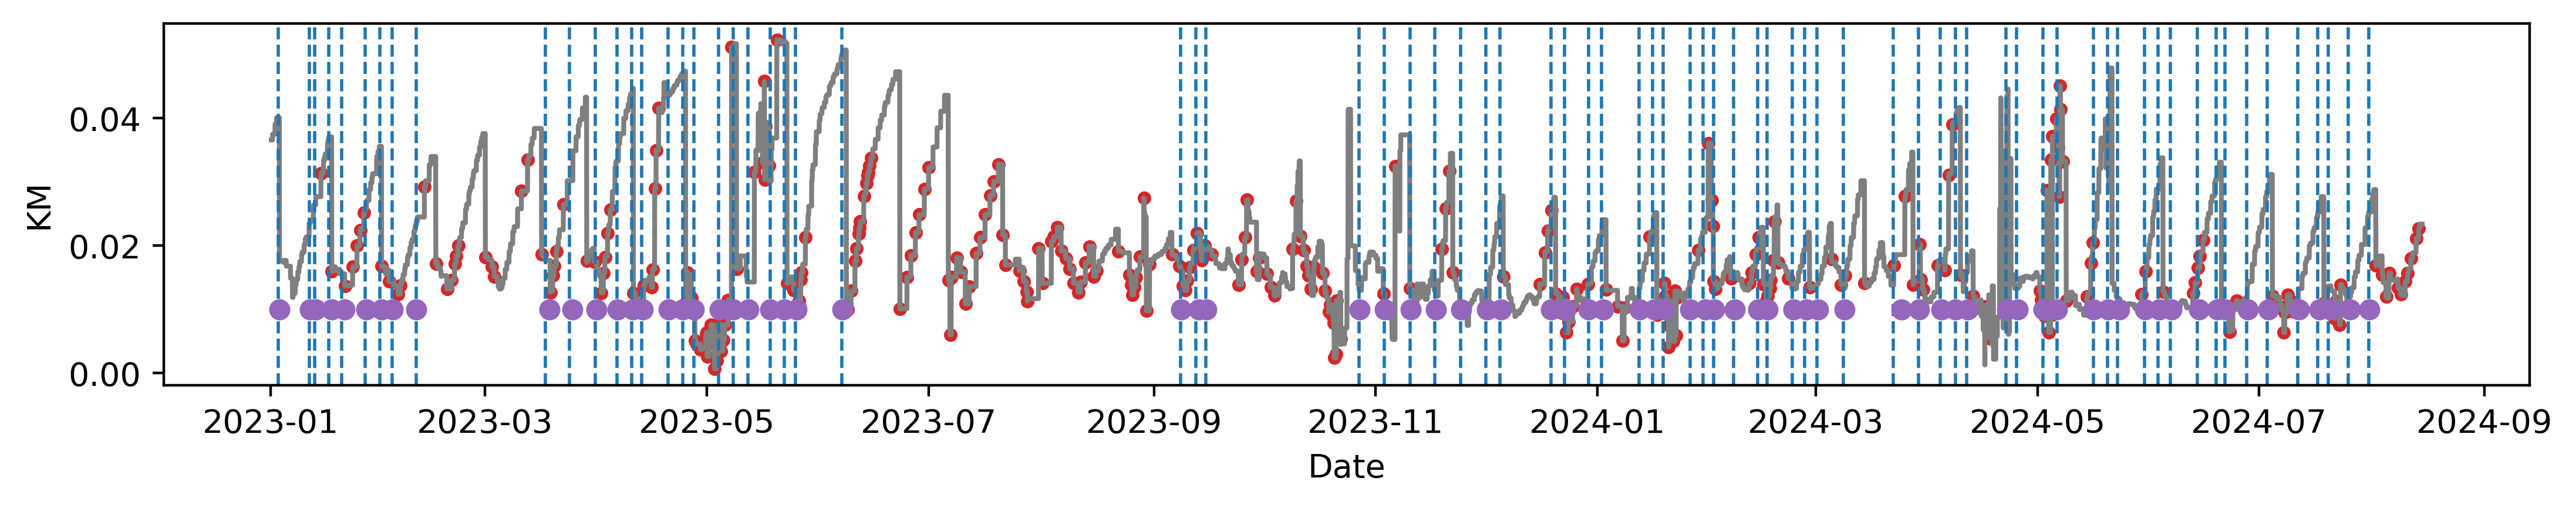

C:\Users\asas4\AppData\Local\Temp\ipykernel_6180\784162945.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  safran_df = pd.concat([safran_df, pd.DataFrame(new_row)], axis=0, ignore_index=True)


36
36
number: 37265, window : 168, level : 95


 28%|██▊       | 3914/14020 [00:00<00:02, 4280.90it/s]C:\Users\asas4\AppData\Local\Temp\ipykernel_6180\3461215531.py:26: RuntimeWarning: invalid value encountered in divide
  D_prime = (CUSUM - (k + 1) / T * CUSUM[-1]) / np.sqrt(lambda_hat)
100%|██████████| 14020/14020 [00:03<00:00, 4147.22it/s]


267


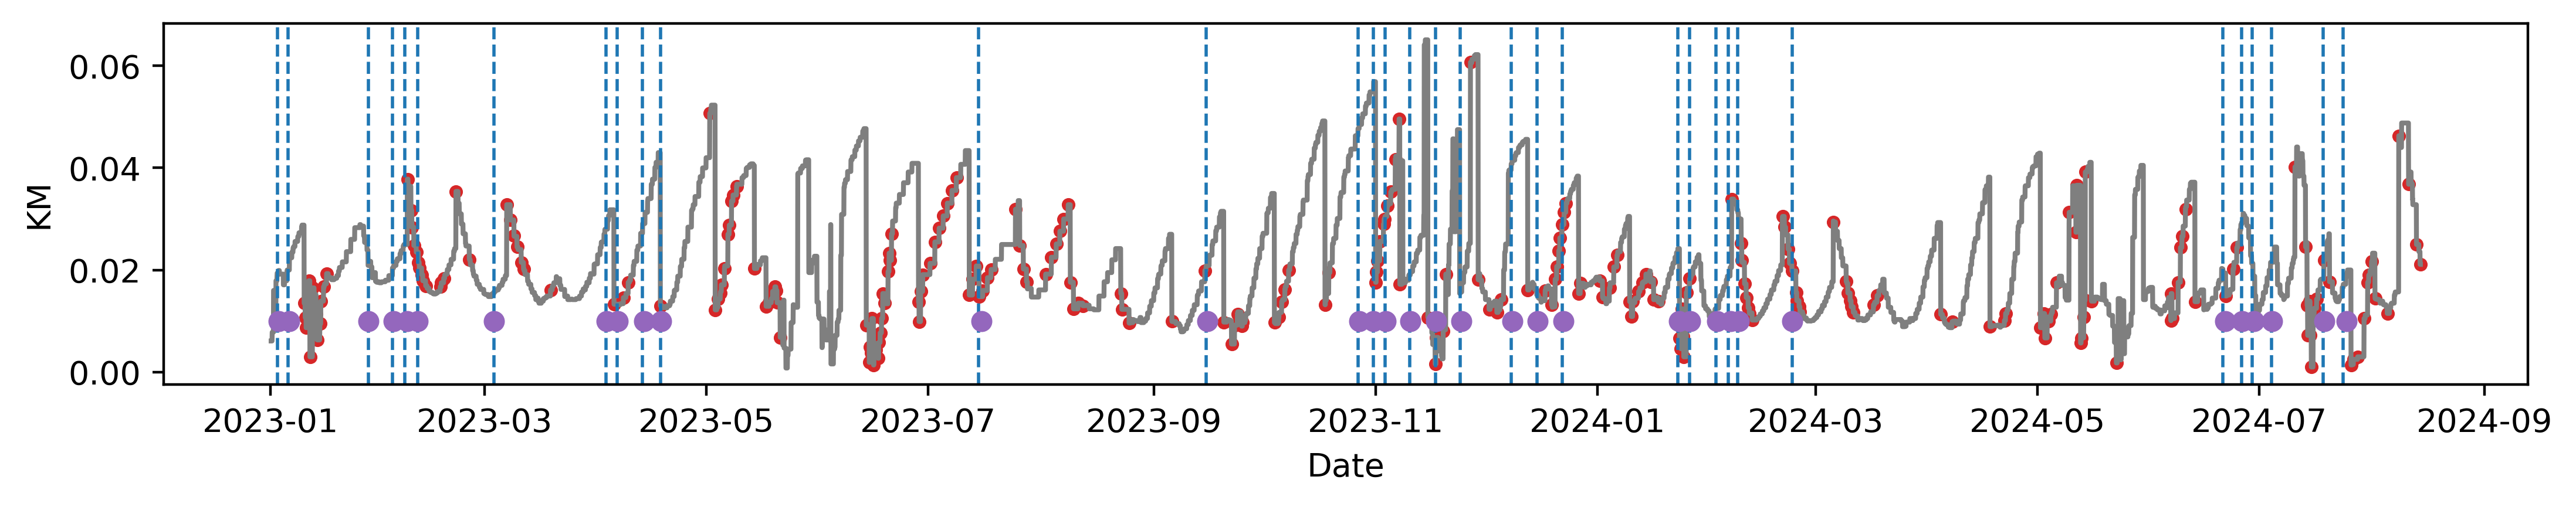

C:\Users\asas4\AppData\Local\Temp\ipykernel_6180\784162945.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  safran_df = pd.concat([safran_df, pd.DataFrame(new_row)], axis=0, ignore_index=True)


66
66
number: 42691, window : 168, level : 95


 28%|██▊       | 3880/14003 [00:00<00:02, 4230.40it/s]C:\Users\asas4\AppData\Local\Temp\ipykernel_6180\3461215531.py:26: RuntimeWarning: invalid value encountered in divide
  D_prime = (CUSUM - (k + 1) / T * CUSUM[-1]) / np.sqrt(lambda_hat)
100%|██████████| 14003/14003 [00:03<00:00, 4082.91it/s]


307


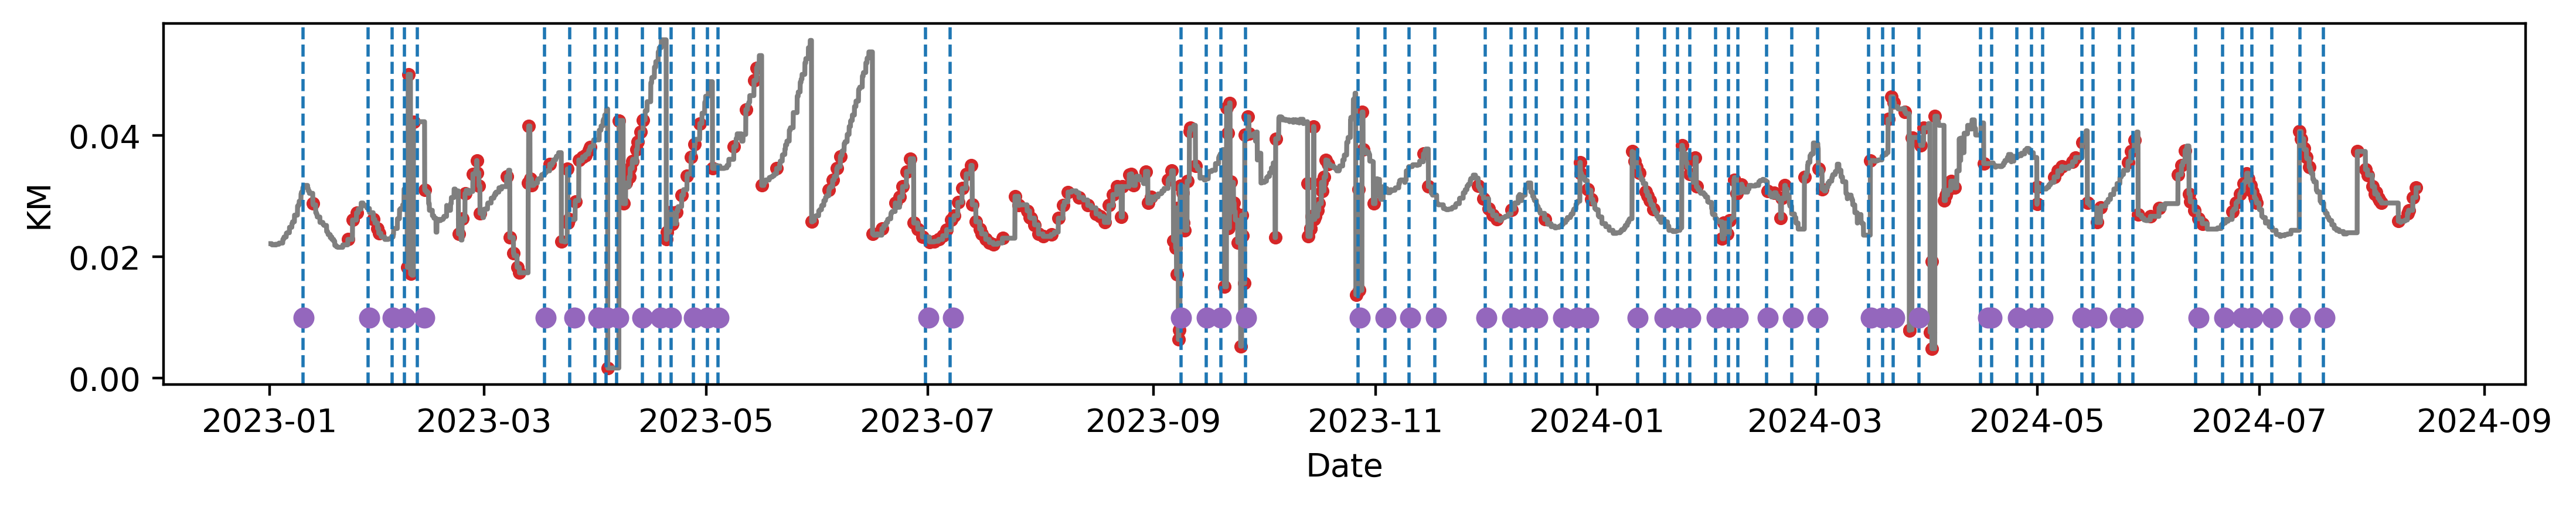

In [147]:
KT_lst = [42984, 37265, 42691]
txt_lst = ['Database\K5A-42984-maneuver-safran.txt', 'Database\K6-37265-maneuver-safran.txt',
           'Database\K7-42691-maneuver-safran.txt']

for i, number in enumerate(KT_lst):
    tle_df = pd.read_csv(f'Database/{number}_tle_change_info.csv')
    tle_df.index = pd.to_datetime(tle_df['time'])
    safran_df = create_dataframe(txt_lst[i])
    safran_idx = safran_df[safran_df['M']>0.8].index
    # safran_idx = safran_df.index
    print(len(safran_idx))
    print(len(safran_df.index))

    change_df = pd.DataFrame()
    second_next_b_index = []
    for idx in safran_idx:
        larger_b_indices = tle_df.index[tle_df.index > idx]
        if len(larger_b_indices) >= 2:
            second_next_b_index.append(larger_b_indices[0])
        else:
            second_next_b_index.append(None)

    change_df[num] = pd.DataFrame(second_next_b_index)
    tle_idx = change_df[num]

    name = 'inclination'
    info_df = pd.read_csv(f'Database/{number}_new.csv', index_col=0)
    info_df = info_df[info_df.index > '2022-12-31 23:59:59'].copy()
    hour_df = info_df[::60].copy()
    diff_value = np.log(hour_df[name].copy()).diff().fillna(0).values

    start_date = hour_df.index[0]
    data_length = len(hour_df)
    time_index = pd.date_range(start=start_date, periods=data_length, freq='h')
    hour_df.index = time_index
    # 24 * 7 * 2, 24 * 7 * 4
    for level in [95]:
        for window in [24 * 7 * 1]:
            print(f'number: {number}, window : {window}, level : {level}')
            ol_lst = ol_detect(diff_value, window, level)
            plot_ol(hour_df, name, ol_lst, number, safran_idx, tle_idx)

# 미분값

In [17]:
# info_df = pd.read_csv(f'Database/42691_new.csv', index_col=0)
# info_df = info_df[info_df.index > '2022-12-31 23:59:59'].copy()
# hour_df = info_df[::60].copy()
# 
# start_date = hour_df.index[0]
# data_length = len(hour_df)
# time_index = pd.date_range(start=start_date, periods=data_length, freq='h')
# hour_df.index = time_index
# hour_df['earth radius'] = hour_df['altitude'] - hour_df['height']
# fig, axes = plt.subplots(10, 1, figsize=(12, 10), dpi=400, sharex=True)
# 
# for i, col_name in enumerate(
#         ['height', 'velocity', 'apogee', 'perigee', 'inclination', 'eccentricity', 'raan', 'longitude', 'altitude',
#          'earth radius']):
#     value = hour_df[col_name].copy().values
#     diff_value = np.log(hour_df[col_name].copy()).diff().fillna(0).values
# 
#     if col_name == 'velocity':
#         value = (hour_df[col_name].copy()) / hour_df['earth radius'].values
# 
#     axes[i].plot(hour_df.index, value, color='tab:blue')
#     axes[i].legend([col_name], loc='upper left', fontsize=8)
# 
# axes[-1].set_xlabel('Date')
# plt.tight_layout()
# plt.show()